## Import libraires

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

## Data loading and understanding

In [2]:
# load the data
data = pd.read_csv('Online+Retail.csv', encoding='unicode_escape')
data.shape

(541909, 8)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# check null values % in each column
data.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

## Data cleaning

In [5]:
# remove null value rows form the data
data = data[~data['Description'].isnull()]
data = data[~data['CustomerID'].isnull()]

In [6]:
data.shape

(406829, 8)

## Data preparation

In retail domain, we make clusters on the basis of following 3 parameters

- **Recency:** for each customer id, when is the most recent transaction over the time period
- **Frequency:** for each customer id, what is the frequency of the transaction over the time period
- **Monetary:** for each customer id, what is the revenue amount over the time period

We will calculate each of the above parameters one by one.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [8]:
# compute recency

# change dtype of InvoiceDate from object to datetime
data['InvoiceDate'] = pd.DatetimeIndex(data['InvoiceDate'])

# compute recency for individual transaction
maxDate = max(data['InvoiceDate'])
data['Recency'] = maxDate - data['InvoiceDate']

# compute recency for individual customer
recency = data.groupby(by = 'CustomerID')['Recency'].min()
recency = recency.reset_index()

# view recency
recency.head()

,CustomerID,Recency
0,12346.0,326 days 07:02:00
1,12347.0,40 days 04:54:00
2,12348.0,76 days 04:06:00
3,12349.0,19 days 07:28:00
4,12350.0,311 days 01:18:00


In [9]:
# compute frequency
frequency = data.groupby(by = 'CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# view frequency
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
# compute monetary
data['Amount'] = data['Quantity'] * data['UnitPrice']
monetary = data.groupby(by = 'CustomerID')['Amount'].sum()
monetary = monetary.reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# view monetary
monetary.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
# build final dataframe by merging above 3 parameters set
df_final = pd.merge(left=recency, right=frequency, on='CustomerID')
df_final = pd.merge(left=df_final, right=monetary, on='CustomerID')

df_final.shape

(4372, 4)

In [12]:
df_final.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326 days 07:02:00,2,0.00
1,12347.0,40 days 04:54:00,182,4310.00
2,12348.0,76 days 04:06:00,31,1797.24
3,12349.0,19 days 07:28:00,73,1757.55
4,12350.0,311 days 01:18:00,17,334.40


In [13]:
# extract days from df_final
df_final['Recency'] = df_final['Recency'].apply(lambda x: pd.Timedelta(x).days)
df_final.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,40,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40


## Outlier analysis and rescaling

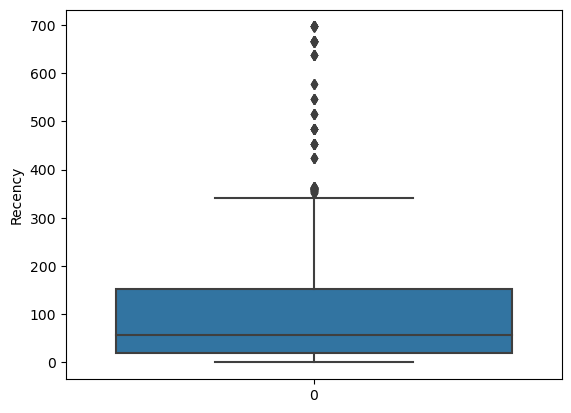

In [14]:
sns.boxplot(df_final['Recency'])
plt.ylabel('Recency')
plt.show()

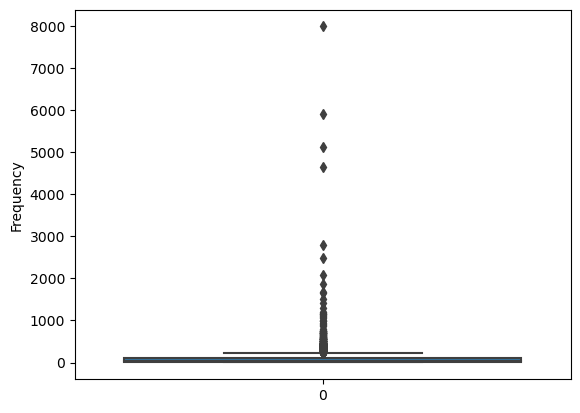

In [15]:
sns.boxplot(df_final['Frequency'])
plt.ylabel('Frequency')
plt.show()

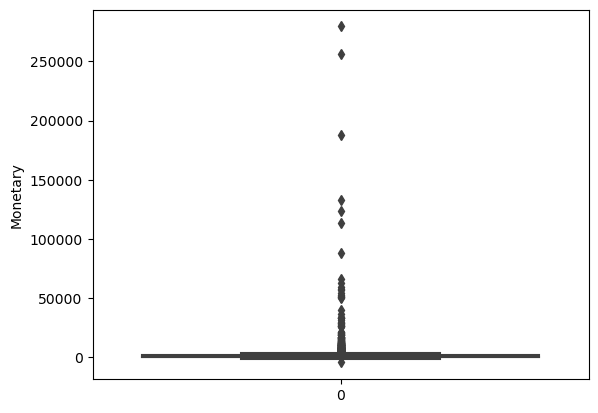

In [16]:
sns.boxplot(df_final['Monetary'])
plt.ylabel('Monetary')
plt.show()

In [17]:
lo = 0.02
hi = 0.98

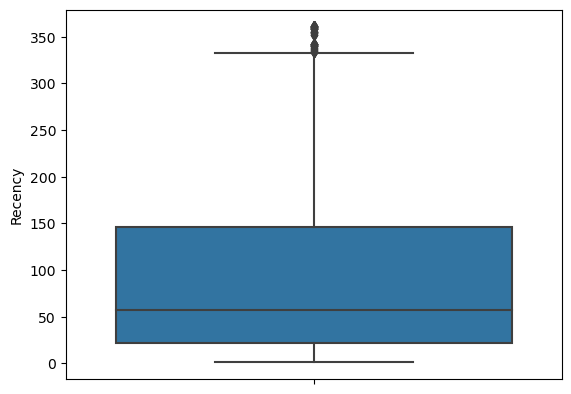

In [18]:
# remove outliers from recency
df_final = df_final[df_final['Recency'] < df_final['Recency'].quantile(hi)]
df_final = df_final[df_final['Recency'] > df_final['Recency'].quantile(lo)]

# box plot for recency
sns.boxplot(data = df_final, y='Recency')
plt.ylabel('Recency')
plt.show()

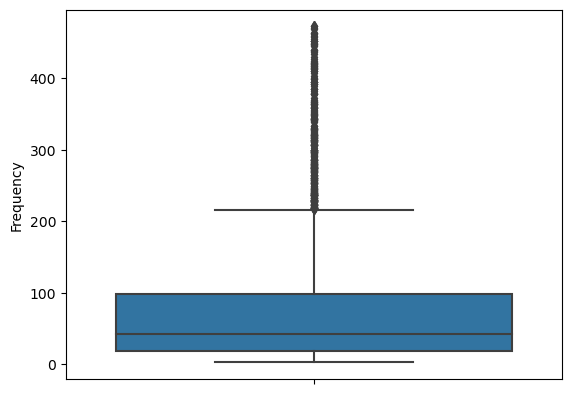

In [19]:
# remove outliers from frequency
df_final = df_final[df_final['Frequency'] < df_final['Frequency'].quantile(hi)]
df_final = df_final[df_final['Frequency'] > df_final['Frequency'].quantile(lo)]

# box plot for frequency
sns.boxplot(data = df_final, y='Frequency')
plt.ylabel('Frequency')
plt.show()

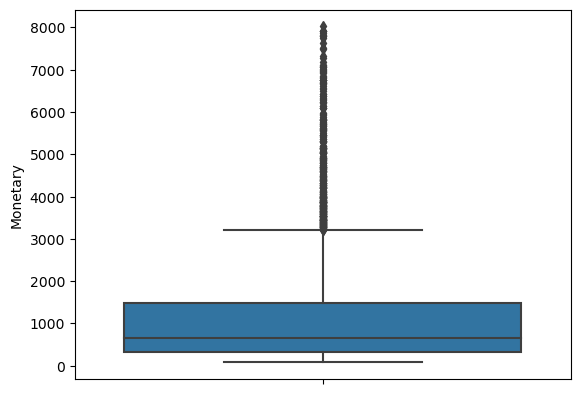

In [20]:
# remove outliers from monetary
df_final = df_final[df_final['Monetary'] < df_final['Monetary'].quantile(hi)]
df_final = df_final[df_final['Monetary'] > df_final['Monetary'].quantile(lo)]

# box plot for monetary
sns.boxplot(data = df_final, y='Monetary')
plt.ylabel('Monetary')
plt.show()

In [21]:
df_final.head()

,CustomerID,Recency,Frequency,Monetary
1,12347.0,40,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40
5,12352.0,73,95,1545.41


In [22]:
# Rescaling using standard scaler
scaler = StandardScaler()
scaledData = df_final.copy()
scaledData[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(df_final[['Recency', 'Frequency', 'Monetary']])
scaledData.head()

,CustomerID,Recency,Frequency,Monetary
1,12347.0,-0.580902,1.354589,2.402027
2,12348.0,-0.181197,-0.515685,0.486728
3,12349.0,-0.814063,0.004524,0.456475
4,12350.0,2.427989,-0.689088,-0.628292
5,12352.0,-0.214506,0.277014,0.294776


## Distribution analysis on parameters

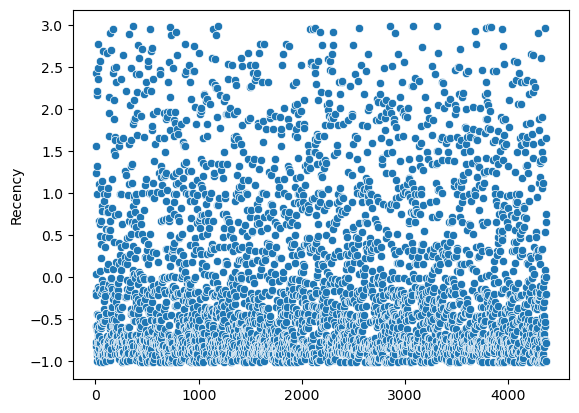

In [23]:
sns.scatterplot(scaledData['Recency'])
plt.show()

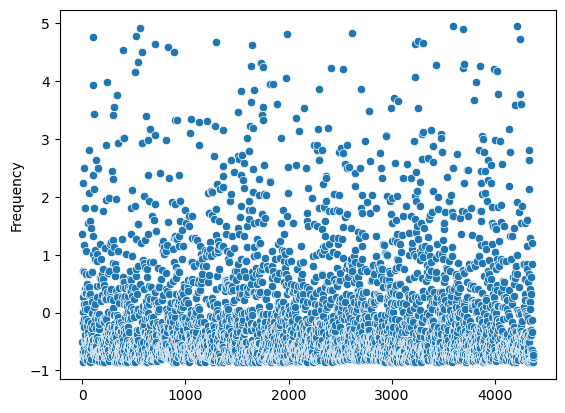

In [24]:
sns.scatterplot(scaledData['Frequency'])
plt.show()

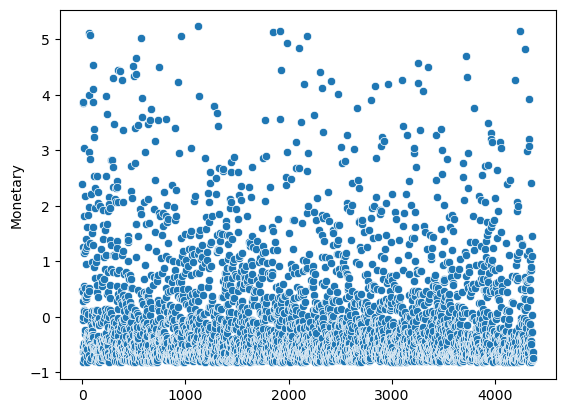

In [25]:
sns.scatterplot(scaledData['Monetary'])
plt.show()

### Hopkins test

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [26]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [27]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(scaledData.drop(columns='CustomerID', axis=1))

0.9219809686864445

## K-Means Clustering

In [28]:
clusters = [2, 3, 4, 5, 6, 7, 8]
scores = []
ssd = []

In [29]:
X = scaledData.drop(columns='CustomerID', axis=1)

for n in clusters:
    model = KMeans(n_clusters=n).fit(X)
    ssd.append(model.inertia_)
    scores.append(silhouette_score(X, model.labels_))

In [30]:
clusterScores = pd.DataFrame({
    'Num of clusters': clusters,
    'SSD': ssd,
    'Silhoutte score': scores
})

clusterScores

,Num of clusters,SSD,Silhoutte score
0,2,6615.033789,0.492358
1,3,3957.444824,0.466756
2,4,3061.598102,0.436027
3,5,2619.144560,0.428642
4,6,2220.520033,0.388415
5,7,1930.373400,0.376326
6,8,1732.275184,0.370351


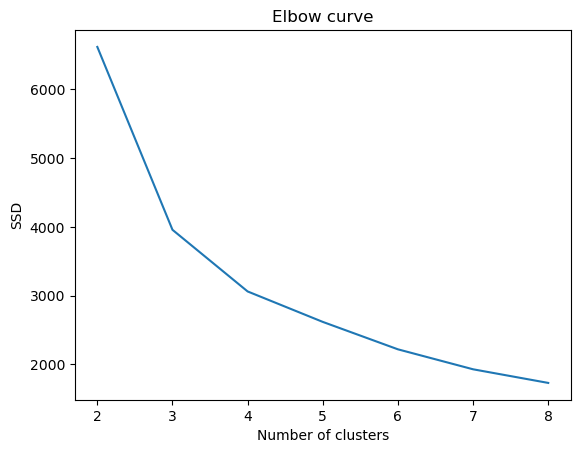

In [31]:
plt.plot(clusterScores['Num of clusters'], clusterScores['SSD'])
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.title('Elbow curve')
plt.show()

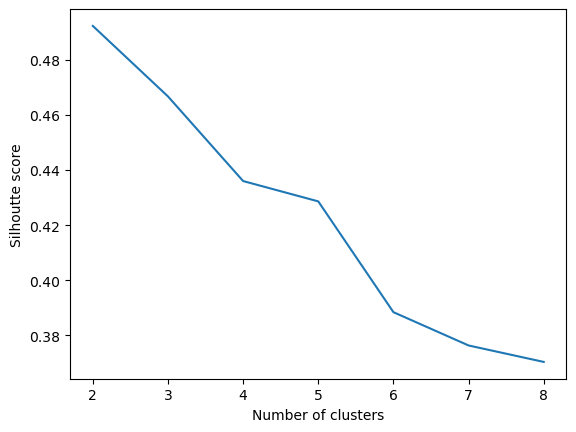

In [32]:
plt.plot(clusterScores['Num of clusters'], clusterScores['Silhoutte score'])
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [33]:
# best model with 3 clusters

X = scaledData.drop(columns='CustomerID', axis=1)
model = KMeans(n_clusters=3).fit(X)

In [34]:
silhouette_score(X, model.labels_)

0.4665329908393838

In [35]:
df_final['Labels'] = model.labels_

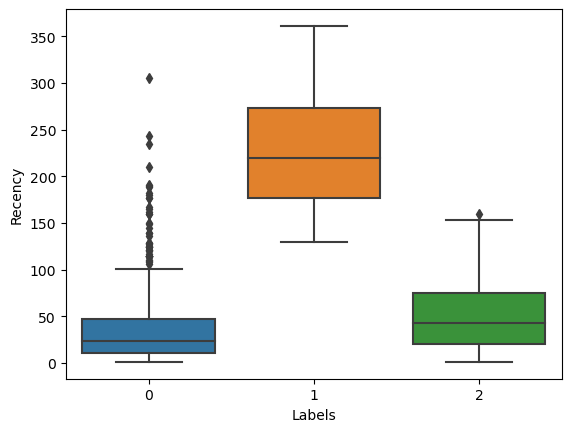

In [36]:
sns.boxplot(data=df_final, x='Labels', y='Recency')
plt.show()

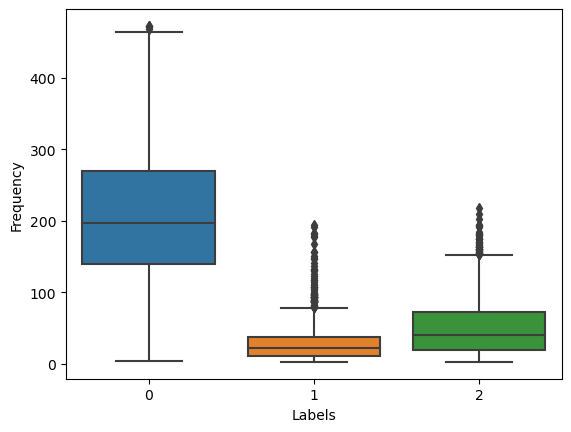

In [37]:
sns.boxplot(data=df_final, x='Labels', y='Frequency')
plt.show()

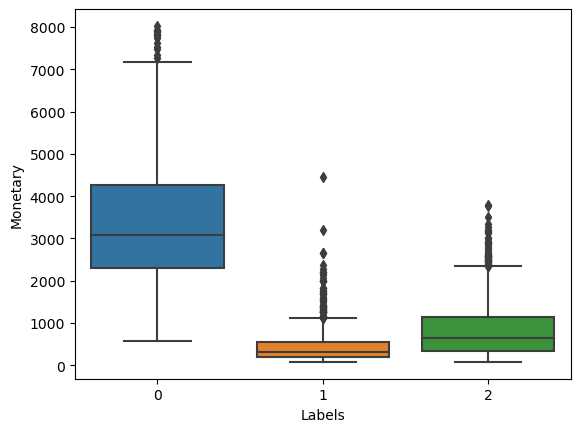

In [38]:
sns.boxplot(data=df_final, x='Labels', y='Monetary')
plt.show()

## Hierarchical clustering

In [49]:
hierarchicalModel = linkage(X, method='complete')

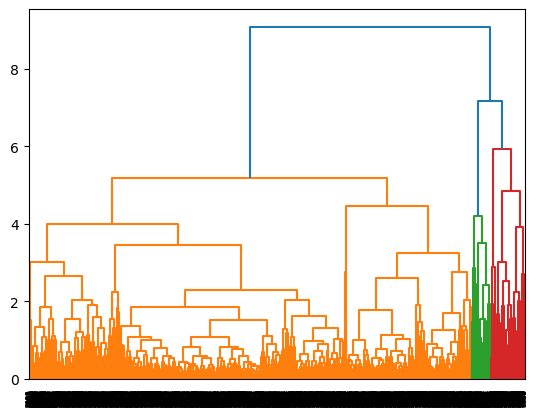

In [50]:
dendrogram(hierarchicalModel)
plt.show()

In [51]:
labels = cut_tree(hierarchicalModel, n_clusters=3)

In [54]:
labels = labels.reshape(-1,)

In [55]:
df_final['Labels_Hierarchical'] = labels

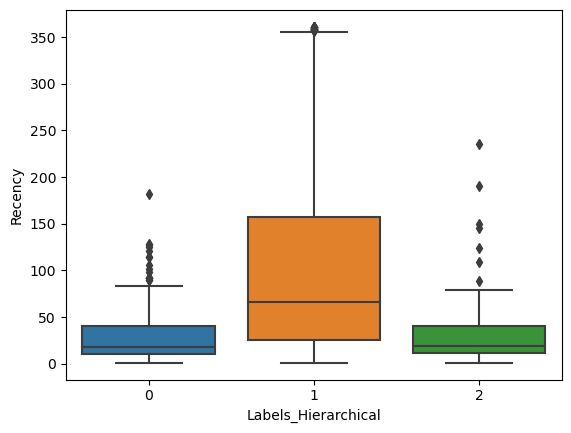

In [57]:
sns.boxplot(data=df_final, x='Labels_Hierarchical', y='Recency')
plt.show()

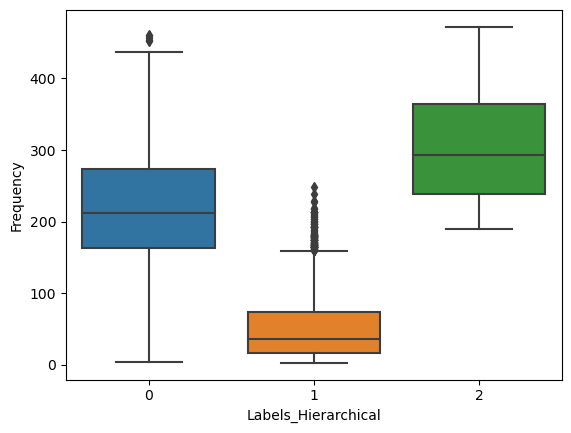

In [58]:
sns.boxplot(data=df_final, x='Labels_Hierarchical', y='Frequency')
plt.show()

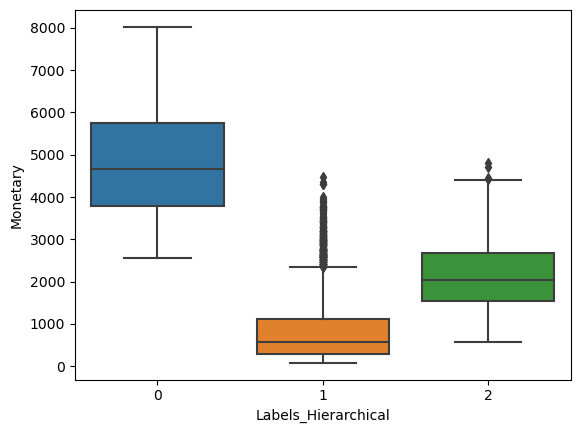

In [59]:
sns.boxplot(data=df_final, x='Labels_Hierarchical', y='Monetary')
plt.show()